# Popularity prediction for Facebook videos

In [32]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.cluster import KMeans

In [33]:
# Load the dataset
df = pd.read_csv("../data/synthetic_time_windows_realistic.csv")
# df = df.drop(columns=["views_672h", "impressions_672h", "likes_672h", "comments_672h"])
df

,video_id_anon,channel_id_anon,video_length,views_final,impressions_final,like_final,comment_final,alpha_hour,views_1h,impressions_1h,...,likes_144h,comments_144h,views_168h,impressions_168h,likes_168h,comments_168h,views_672h,impressions_672h,likes_672h,comments_672h
0,58006937d7,bab3e0fb35,785,60904.0,96520.0,1094.0,51.0,7.682197,5075.333333,8043.333333,...,91.166667,4.250000,5075.333333,8043.333333,91.166667,4.250000,5075.333333,8043.333333,91.166667,4.250000
1,aed6fc904f,5d96a53e86,209,10085.0,18922.0,326.0,1.0,19.585142,840.416667,1576.833333,...,27.166667,0.083333,840.416667,1576.833333,27.166667,0.083333,840.416667,1576.833333,27.166667,0.083333
2,91423a16a2,cd0c9afcf7,412,130986.0,286634.0,760.0,116.0,3.223178,10915.500000,23886.166667,...,63.333333,9.666667,10915.500000,23886.166667,63.333333,9.666667,10915.500000,23886.166667,63.333333,9.666667
3,ac4f416391,7687f7c227,186,886216.0,1160128.0,29008.0,184.0,8.395225,73851.333333,96677.333333,...,2417.333333,15.333333,73851.333333,96677.333333,2417.333333,15.333333,73851.333333,96677.333333,2417.333333,15.333333
4,061287596b,a45ac131cb,338,534100.0,1006887.0,7151.0,165.0,1.597376,44508.333333,83907.250000,...,595.916667,13.750000,44508.333333,83907.250000,595.916667,13.750000,44508.333333,83907.250000,595.916667,13.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16568,490eec4ad5,e5c49ebdb1,47,22203.0,47811.0,259.0,33.0,4.122788,1850.250000,3984.250000,...,21.583333,2.750000,1850.250000,3984.250000,21.583333,2.750000,1850.250000,3984.250000,21.583333,2.750000
16569,213c24922a,2d3e412551,180,22848.0,44748.0,64.0,8.0,25.985376,1904.000000,3729.000000,...,5.333333,0.666667,1904.000000,3729.000000,5.333333,0.666667,1904.000000,3729.000000,5.333333,0.666667
16570,698f8feb92,a628b4f3b3,180,344287.0,605982.0,1957.0,28.0,7.791411,28690.583333,50498.500000,...,163.083333,2.333333,28690.583333,50498.500000,163.083333,2.333333,28690.583333,50498.500000,163.083333,2.333333
16571,cd3777be80,2ffab40309,231,22780.0,50854.0,504.0,14.0,69.816137,1898.333333,4237.833333,...,42.000000,1.166667,1898.333333,4237.833333,42.000000,1.166667,1898.333333,4237.833333,42.000000,1.166667


In [34]:
df.describe().T.to_csv("../data/video_timeseries_data_description.csv")

In [35]:
# Compute alpha-lifespan from the actual time series
alpha = 0.5
time_points = [1, 3, 6, 12, 24, 48, 72, 96, 120, 144, 168, 672]

# For each video, we find the earliest hour h at which views_h >= alpha * views_final.
def compute_alpha_lifespan(row, alpha=0.5):
    final_views = row["views_final"]
    threshold = alpha * final_views

    # Go in ascending order of time_points
    for h in time_points:
        # select the column name corresponding to the current time point
        colname = f"views_{h}h"
        val_at_h = row[colname]
        # if the value crosses the threshold, return the time point
        if val_at_h >= threshold:
            return h
    # If it never reaches alpha * final_views, fallback to the maximum time window
    return 672

df["alpha_lifespan"] = df.apply(lambda r: compute_alpha_lifespan(r, alpha=alpha), axis=1)

In [36]:
df["alpha_lifespan"].value_counts()

alpha_lifespan
672    16573
Name: count, dtype: int64

ValueError: Too many bins for data range. Cannot create 10 finite-sized bins.

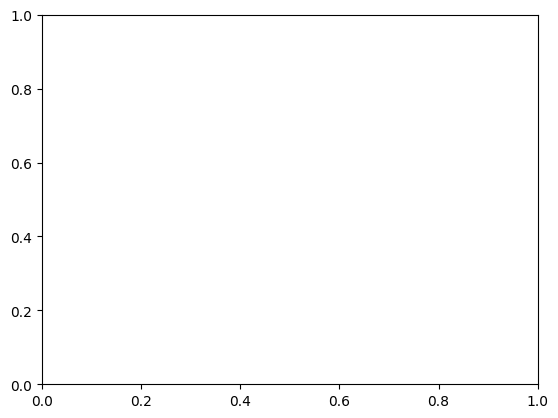

In [37]:
(df['views_168h'] / df['views_final']).hist()